# Credentials

__Put Testnet or Prod credentials here__:
(Testnet here: https://testnet.binancefuture.com/en/futures/BTCUSDT)

Testnet resets each day, but your credentials wont change.

In [2]:
api_key = "6ce63f3406fd8ebbff01054a66c25fe3c851c45932088c8ca3131a7005188462"
secret_key = "aa3ea32929252467fa5ffeac5818c95beabfb5dba691ef445e7eaa31ea0d15f6"

# Python Api Wrapper

It is important to install python wrappers of binance API (one is not made by Binance, use at your own risk), just run on terminal:

__pip install python-binance__

__pip install binance-futures-connector__

Currently unofficial wrapper has problems retrieving real-time prices (problem with websockets), so we use the official Api wrapper of Binance to this task.

Useful links:

__Binance Official Api Docs__: https://binance-docs.github.io/apidocs/futures/en/#account-trades-endpoints

__Unofficial Python Api Wrapper__: https://python-binance.readthedocs.io/en/latest/overview.html

__Official Binance Api Wrapper__: https://github.com/binance/binance-futures-connector-python 

Api Wrapper sometimes its not specific on arguments for functions, so it´s useful to check that args on official Api docs

__This is the code for live streaming that is going to be replaced with official api__

In [5]:
from binance import ThreadedWebsocketManager
import time
twm = ThreadedWebsocketManager(testnet = True)
twm.start()
twm.start_kline_futures_socket(callback = stream_candles, symbol = "BTCUSDT", interval = "1m")
time.sleep(10)
twm.stop()

'btcusdt_perpetual@continuousKline_1m'

CANCEL read_loop
Task exception was never retrieved
future: <Task finished name='Task-8' coro=<ThreadedApiManager.start_listener() done, defined at /home/mauricio/anaconda3/lib/python3.9/site-packages/binance/threaded_stream.py:42> exception=RuntimeError("Task <Task pending name='Task-14' coro=<Queue.get() running at /home/mauricio/anaconda3/lib/python3.9/asyncio/queues.py:166> cb=[_release_waiter(<Future pendi...112a0c370>()]>)() at /home/mauricio/anaconda3/lib/python3.9/asyncio/tasks.py:416]> got Future <Future pending> attached to a different loop")>
Traceback (most recent call last):
  File "/home/mauricio/anaconda3/lib/python3.9/site-packages/binance/threaded_stream.py", line 46, in start_listener
    msg = await asyncio.wait_for(s.recv(), 3)
  File "/home/mauricio/anaconda3/lib/python3.9/asyncio/tasks.py", line 479, in wait_for
    return fut.result()
  File "/home/mauricio/anaconda3/lib/python3.9/site-packages/binance/streams.py", line 197, in recv
    res = await asyncio.wait_f

__Useful code for streaming__

In [1]:
import time
#import logging
#from binance.lib.utils import config_logging
from binance.websocket.cm_futures.websocket_client import CMFuturesWebsocketClient

#config_logging(logging, logging.DEBUG)


def message_handler(message):
    print(message)


my_client = CMFuturesWebsocketClient()
my_client.start()

my_client.kline(
    symbol="btcusd_perp",
    id=12,
    interval="1m",
    callback=message_handler,
)

time.sleep(10)

#logging.debug("closing ws connection")
my_client.stop()

{'id': 12, 'result': None}
{'e': 'kline', 'E': 1660196910471, 's': 'BTCUSD_PERP', 'k': {'t': 1660196880000, 'T': 1660196939999, 's': 'BTCUSD_PERP', 'i': '1m', 'f': 503634938, 'L': 503635180, 'o': '24634.7', 'c': '24633.5', 'h': '24636.7', 'l': '24627.9', 'v': '11179', 'n': 243, 'x': False, 'q': '45.38384832', 'V': '5765', 'Q': '23.40584244', 'B': '0'}}
{'e': 'kline', 'E': 1660196911325, 's': 'BTCUSD_PERP', 'k': {'t': 1660196880000, 'T': 1660196939999, 's': 'BTCUSD_PERP', 'i': '1m', 'f': 503634938, 'L': 503635181, 'o': '24634.7', 'c': '24633.5', 'h': '24636.7', 'l': '24627.9', 'v': '11180', 'n': 244, 'x': False, 'q': '45.38790783', 'V': '5766', 'Q': '23.40990195', 'B': '0'}}
{'e': 'kline', 'E': 1660196911577, 's': 'BTCUSD_PERP', 'k': {'t': 1660196880000, 'T': 1660196939999, 's': 'BTCUSD_PERP', 'i': '1m', 'f': 503634938, 'L': 503635240, 'o': '24634.7', 'c': '24637.9', 'h': '24637.9', 'l': '24627.9', 'v': '13463', 'n': 303, 'x': False, 'q': '54.65514345', 'V': '8049', 'Q': '32.67713757', 

# Streaming data

This is a simple class for streaming candles. It adds bars to a dataframe on a specified time.

__Important__: You maybe need to restart kernel each time you close a connection.

In [7]:
from binance.websocket.cm_futures.websocket_client import CMFuturesWebsocketClient
import pandas as pd
import numpy as np

In [2]:
class FuturesTrader():
    def __init__(self, interval = "1m", symbol="btcusd"):
        self.stream = None
        self.data = pd.DataFrame(columns = ["Date", "Open", "High", "Low", "Close", "Volume", "Complete"])
        self.data["Date"] = pd.to_datetime(self.data.iloc[:,0], unit = "ms")
        self.data.set_index("Date", inplace = True)
        self.interval = interval
        self.symbol = symbol
        
    def message_handler(self, msg):
        if 'result' in msg.keys(): #skip first message
            return
        # extract the required items from msg
        event_time = pd.to_datetime(msg["E"], unit = "ms")
        start_time = pd.to_datetime(msg["k"]["t"], unit = "ms")
        first   = float(msg["k"]["o"])
        high    = float(msg["k"]["h"])
        low     = float(msg["k"]["l"])
        close   = float(msg["k"]["c"])
        volume  = float(msg["k"]["v"])
        complete=       msg["k"]["x"]
        
        # print out
        print(".", end = "", flush = True) 
    
        # feed df (add new bar / update latest bar)
        self.data.loc[start_time] = [first, high, low, close, volume, complete]
        
    def start_streaming(self):
        self.stream = CMFuturesWebsocketClient()
        self.stream.start()
        self.stream.kline(
            symbol=self.symbol.lower() +"_perp",
            id=1,
            interval=self.interval,
            callback=self.message_handler,
        )
        
    def stop_streaming(self):
        self.stream.stop()

In [3]:
trader = FuturesTrader(interval="1m", symbol="btcusd")

In [4]:
trader.start_streaming()

....

In [5]:
trader.stop_streaming()

In [6]:
trader.data

,Open,High,Low,Close,Volume,Complete
Date,,,,,,
2022-12-04 19:20:00,17079.3,17079.4,17076.4,17076.4,5174.0,True
2022-12-04 19:21:00,17076.4,17076.4,17075.5,17075.5,28.0,False


# Retrieving historical data

When running the bot trader, we need the latest historical data to process all the needed metrics in real time. This method retrieves the latest __n__ candlesticks data on the required interval.

This lines are useful for saving candlesticks info for Neural Networks

api info:  https://binance-docs.github.io/apidocs/futures/en/#kline-candlestick-data

api wrapper method info: https://python-binance.readthedocs.io/en/latest/market_data.html#id7

__Important__: 

1. The used __function "futures_historical_klines" doesn't behave according the restrictions of binance api__, for example, the limit is not 1500 records as binance says. For example, if you want more than 1500 candlesticks, i think it makes more than one request and prepares the result for you...

2. Also, notice that __the code shows all the info retrieved by Binance API__, if you want one that is not used, add it to section "Use this info".

3. Notice that __the last record retrieved has not completed his time period__, so its not accurate info.

In [1]:
api_key = "6ce63f3406fd8ebbff01054a66c25fe3c851c45932088c8ca3131a7005188462"
secret_key = "aa3ea32929252467fa5ffeac5818c95beabfb5dba691ef445e7eaa31ea0d15f6"

In [2]:
from binance.client import Client
from datetime import datetime, timedelta
import pandas as pd

#### VARIABLES ####
max_number_of_candles = 100000 
interval_of_candles = "1m"
symbol = "btcusdt"
#### Available intervals for candles ####
time_to_past = {
 "1m"  : timedelta(minutes=max_number_of_candles),
 "3m"  : timedelta(minutes=max_number_of_candles*3),
 "5m"  : timedelta(minutes=max_number_of_candles*5),
 "15m" : timedelta(minutes=max_number_of_candles*15),
 "30m" : timedelta(minutes=max_number_of_candles*30),
 "1h"  : timedelta(hours=max_number_of_candles),
 "2h"  : timedelta(hours=max_number_of_candles*2),
 "4h"  : timedelta(hours=max_number_of_candles*4),
 "6h"  : timedelta(hours=max_number_of_candles*6),
 "8h"  : timedelta(hours=max_number_of_candles*8),
 "12h" : timedelta(hours=max_number_of_candles*12),
 "1d"  : timedelta(days=max_number_of_candles),
 "3d"  : timedelta(days=max_number_of_candles*3),
 "1w"  : timedelta(days=max_number_of_candles*7),
 "1M"  : timedelta(days=max_number_of_candles*28) #this may give less than the desired candles because each month has different amount of days
}
#### Request info ####

client = Client(api_key = api_key, api_secret = secret_key, tld = "com", testnet = True) # Testnet!!!

now = datetime.utcnow()
past = str(now - time_to_past[interval_of_candles])

bars = client.futures_historical_klines(symbol = symbol, 
                                        interval = interval_of_candles, 
                                        start_str =past,
                                        end_str = None)
#### Prepare dataframe ####
df = pd.DataFrame(bars)
df["Date"] = pd.to_datetime(df.iloc[:,0], unit = "ms")
#### Info given by Binance ####
df.columns = ["Open Time", "Open", "High", "Low", "Close", "Volume",
              "Close Time", "Quote Asset Volume", "Number of Trades",
              "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore", "Date"]
#### Use this info ####
use_columns = ["Date", "Open", "High", "Low", "Close", "Volume", "Quote Asset Volume", "Number of Trades",
              "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume"]
######################
df = df[use_columns].copy()
df.set_index("Date", inplace = True)
for column in df.columns:
    df[column] = pd.to_numeric(df[column], errors = "coerce")
df

,Open,High,Low,Close,Volume,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume
Date,,,,,,,,,
2022-10-10 20:36:00,19254.4,19262.4,19250.5,19254.8,11.643,2.242013e+05,22,11.377,2.190807e+05
2022-10-10 20:37:00,19250.5,19250.5,19240.0,19240.0,26.523,5.105258e+05,17,17.041,3.280108e+05
2022-10-10 20:38:00,19240.0,19246.5,19240.0,19240.0,5.239,1.008183e+05,14,3.044,5.858581e+04
2022-10-10 20:39:00,19240.4,19250.5,19238.2,19243.3,43.627,8.395514e+05,17,29.602,5.697187e+05
2022-10-10 20:40:00,19243.3,19250.5,19229.3,19234.1,47.109,9.066890e+05,44,44.205,8.508461e+05
...,...,...,...,...,...,...,...,...,...
2022-12-19 07:13:00,16789.0,16789.0,16752.5,16752.5,43.053,7.218774e+05,44,17.290,2.902818e+05
2022-12-19 07:14:00,16789.0,16790.0,16752.5,16752.5,97.514,1.635953e+06,60,61.336,1.029771e+06
2022-12-19 07:15:00,16788.9,16790.0,16750.0,16790.0,147.176,2.467849e+06,65,67.309,1.129947e+06


Then we can save the data to prevent requesting too many times from futures api

In [3]:
storage = "data/dic19_1m.csv"
df.to_csv(storage)

You can load the data running:

In [26]:
loaded = pd.read_csv(storage, index_col = "Date", parse_dates = ["Date"])
loaded

,Open,High,Low,Close,Volume
Date,,,,,
2022-07-12 11:15:00,19695.3,19960.0,19688.2,19729.8,646.946
2022-07-12 11:20:00,19729.8,20193.9,19713.8,19713.8,985.261
2022-07-12 11:25:00,19713.8,20193.9,19700.0,19772.7,296.593
2022-07-12 11:30:00,19772.7,19823.3,19755.8,19823.3,228.892
2022-07-12 11:35:00,19799.4,19823.3,19737.1,19766.9,223.029
...,...,...,...,...,...
2022-08-16 04:10:00,24500.0,24550.0,24450.0,24550.0,333.414
2022-08-16 04:15:00,24451.9,24550.0,24450.0,24450.0,357.999
2022-08-16 04:20:00,24508.3,24550.0,24450.0,24508.3,358.612


# Combining historical and streaming data in a class

This is a class that __keeps historical data and updates it with streaming info__. It is useful for our trading bot to have accurate metrics when first loading.

In [2]:
from binance.client import Client
from binance.websocket.cm_futures.websocket_client import CMFuturesWebsocketClient
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [3]:
class FuturesTrader():
    def __init__(self, symbol="btcusd", testnet = True):
        ####API CONNECTIONS ####
        self.stream = None
        self.client = Client(api_key = api_key, api_secret = secret_key, tld = "com", testnet = testnet)
        #######################
        self.data = None
        self.symbol = symbol 
        
    def message_handler(self, msg):
        if 'result' in msg.keys(): #skip first message
            return
        # extract the required items from msg
        event_time = pd.to_datetime(msg["E"], unit = "ms")
        start_time = pd.to_datetime(msg["k"]["t"], unit = "ms")
        first   = float(msg["k"]["o"])
        high    = float(msg["k"]["h"])
        low     = float(msg["k"]["l"])
        close   = float(msg["k"]["c"])
        volume  = float(msg["k"]["v"])
        complete=       msg["k"]["x"]
        
        # print out
        print(".", end = "", flush = True) 
    
        # feed df (add new bar / update latest bar)
        self.data.loc[start_time] = [first, high, low, close, volume, complete]
        # prepare features and define strategy/trading positions whenever the latest bar is complete
        if complete == True:
            print("candle completed", end="")
            #execute trading functions here!!
        
    def start_streaming(self, interval="1m"):
        self.stream = CMFuturesWebsocketClient()
        self.stream.start()
        self.stream.kline(
            symbol=self.symbol.lower() +"_perp",
            id=1,
            interval=interval,
            callback=self.message_handler,
        )
        
    def stop_streaming(self):
        self.stream.stop()
        
    def get_most_recent_data(self, num_candles=100, interval = "1m"):
        #### Get start time for candles ####
        now = datetime.utcnow()
        past = str(now - self.available_intervals(num_candles)[interval])
        #### "BTCUSD" is not valid with this method ####
        symbol = self.symbol + "t" if self.symbol.endswith('usd') else self.symbol
        #### Request candles and prepare the df ####
        bars = self.client.futures_historical_klines(symbol = symbol, 
                                        interval = interval, 
                                        start_str =past,
                                        end_str = None)
        df = pd.DataFrame(bars)
        df["Date"] = pd.to_datetime(df.iloc[:,0], unit = "ms")
        df.columns = ["Open Time", "Open", "High", "Low", "Close", "Volume",
                      "Close Time", "Quote Asset Volume", "Number of Trades",
                      "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore", "Date"]
        df = df[["Date", "Open", "High", "Low", "Close", "Volume"]].copy()
        df.set_index("Date", inplace = True)
        for column in df.columns:
            df[column] = pd.to_numeric(df[column], errors = "coerce")
        df["Complete"] = [True for row in range(len(df)-1)] + [False]    
        self.data = df
    
    def start_trading(self, num_candles = 100, interval = "1m"):
        if interval in self.available_intervals(num_candles).keys():
            self.get_most_recent_data(num_candles = num_candles, interval=interval)
            self.start_streaming(interval)
        else:
            print("That interval is not available")
            
    def stop_trading(self):
        self.stop_streaming()
        #print ending metrics here!!
        
    def available_intervals(self, candles_required):
        '''
        Helper function for "get_most_recent_data" method.
        
        '''
        return {
            "1m"  : timedelta(minutes=candles_required),
            "3m"  : timedelta(minutes=candles_required*3),
            "5m"  : timedelta(minutes=candles_required*5),
            "15m" : timedelta(minutes=candles_required*15),
            "30m" : timedelta(minutes=candles_required*30),
            "1h"  : timedelta(hours=candles_required),
            "2h"  : timedelta(hours=candles_required*2),
            "4h"  : timedelta(hours=candles_required*4),
            "6h"  : timedelta(hours=candles_required*6),
            "8h"  : timedelta(hours=candles_required*8),
            "12h" : timedelta(hours=candles_required*12),
            "1d"  : timedelta(days=candles_required),
            "3d"  : timedelta(days=candles_required*3),
            "1w"  : timedelta(days=candles_required*7),
            "1M"  : timedelta(days=candles_required*28) #this may give less than the desired candles because each month has different amount of days
        }     

In [4]:
trader = FuturesTrader(symbol="btcusd", testnet = True)

In [5]:
trader.start_trading(interval="1m", num_candles=300)

...................................candle completed...

In [6]:
trader.stop_trading()

In [7]:
trader.data

,Open,High,Low,Close,Volume,Complete
Date,,,,,,
2022-12-05 16:16:00,17092.0,17093.2,17064.1,17078.6,87.966,True
2022-12-05 16:17:00,17060.0,17086.4,17030.0,17070.0,164.884,True
2022-12-05 16:18:00,17068.3,17075.7,17064.4,17075.7,116.341,True
2022-12-05 16:19:00,17073.8,17075.0,17063.0,17063.0,155.759,True
2022-12-05 16:20:00,17061.8,17063.2,17000.0,17057.5,201.164,True
...,...,...,...,...,...,...
2022-12-05 21:12:00,16954.0,16955.0,16950.7,16950.7,121.852,True
2022-12-05 21:13:00,16950.7,16954.7,16947.8,16949.7,35.471,True
2022-12-05 21:14:00,16953.8,16953.8,16950.0,16950.0,61.108,True


In [8]:
trader.data.to_csv("data/example.csv")

# How to prepare data

Let´s load historical data saved with a method of a section above

In [75]:
import pandas as pd
import numpy as np

In [76]:
df = pd.read_csv('out.csv', index_col = "Date", parse_dates = ["Date"])
df

,Open,High,Low,Close,Volume
Date,,,,,
2022-08-04 05:50:00,23780.0,23780.0,23198.0,23198.0,84.921
2022-08-04 05:51:00,23228.2,23900.0,23198.0,23900.0,84.941
2022-08-04 05:52:00,23852.2,23898.0,23198.0,23898.0,132.174
2022-08-04 05:53:00,23898.0,23900.0,23198.0,23228.2,74.257
2022-08-04 05:54:00,23520.4,23946.0,23198.0,23653.4,83.717
...,...,...,...,...,...
2022-08-11 04:26:00,24344.5,24344.5,24200.0,24317.6,75.895
2022-08-11 04:27:00,24312.2,24317.6,24150.0,24308.0,99.008
2022-08-11 04:28:00,24310.1,24313.6,24305.6,24311.0,21.804


We can calculate returns by period. In this case we are going to do it for the close price.

__Important__: This is not the percentage of close price changing. Uses np.log because the cummulative sum of these rows helps to know if at the end the close price grows (>0) or not (<=0).

In [77]:
df["returns"] = np.log(df["Close"] / df["Close"].shift())
#cummulative returns, same results as (current closing price / first closing price)
df["creturns"] = df["returns"].cumsum().apply(np.exp) 
df

,Open,High,Low,Close,Volume,returns,creturns
Date,,,,,,,
2022-08-04 05:50:00,23780.0,23780.0,23198.0,23198.0,84.921,NaN,NaN
2022-08-04 05:51:00,23228.2,23900.0,23198.0,23900.0,84.941,0.029812,1.030261
2022-08-04 05:52:00,23852.2,23898.0,23198.0,23898.0,132.174,-0.000084,1.030175
2022-08-04 05:53:00,23898.0,23900.0,23198.0,23228.2,74.257,-0.028428,1.001302
2022-08-04 05:54:00,23520.4,23946.0,23198.0,23653.4,83.717,0.018140,1.019631
...,...,...,...,...,...,...,...
2022-08-11 04:26:00,24344.5,24344.5,24200.0,24317.6,75.895,-0.001106,1.048263
2022-08-11 04:27:00,24312.2,24317.6,24150.0,24308.0,99.008,-0.000395,1.047849
2022-08-11 04:28:00,24310.1,24313.6,24305.6,24311.0,21.804,0.000123,1.047978


Then, we can calculate a strategy. For simplicity, let´s use SMA crossing signals to make trades.

In [78]:
df["SMA_S"] = df["Close"].rolling(2).mean() # add short sma
df["SMA_L"] = df["Close"].rolling(200).mean()
df.dropna(inplace=True)
df

,Open,High,Low,Close,Volume,returns,creturns,SMA_S,SMA_L
Date,,,,,,,,,
2022-08-04 09:09:00,23597.3,23597.3,23002.1,23400.0,7.872,0.017155,1.008708,23201.00,23371.8485
2022-08-04 09:10:00,23596.7,23649.0,23010.0,23601.7,11.586,0.008583,1.017402,23500.85,23373.8670
2022-08-04 09:11:00,23636.0,23649.0,23002.0,23600.0,76.243,-0.000072,1.017329,23600.85,23372.3670
2022-08-04 09:12:00,23600.0,23633.0,23002.1,23300.0,72.692,-0.012793,1.004397,23450.00,23369.3770
2022-08-04 09:13:00,23300.0,23630.0,23002.1,23270.8,29.588,-0.001254,1.003138,23285.40,23369.5900
...,...,...,...,...,...,...,...,...,...
2022-08-11 04:26:00,24344.5,24344.5,24200.0,24317.6,75.895,-0.001106,1.048263,24331.05,24142.5940
2022-08-11 04:27:00,24312.2,24317.6,24150.0,24308.0,99.008,-0.000395,1.047849,24312.80,24144.5960
2022-08-11 04:28:00,24310.1,24313.6,24305.6,24311.0,21.804,0.000123,1.047978,24309.50,24146.2130


Now we test the strategy

In [79]:
df["position"] = np.where(df["SMA_S"] > df["SMA_L"], 1, -1)
df["strategy"] = df["position"].shift(1) * df["returns"] #checks if strategy was succesful on each period (>0)
df["cstrategy"] = df["strategy"].cumsum().apply(np.exp)
df

,Open,High,Low,Close,Volume,returns,creturns,SMA_S,SMA_L,position,strategy,cstrategy
Date,,,,,,,,,,,,
2022-08-04 09:09:00,23597.3,23597.3,23002.1,23400.0,7.872,0.017155,1.008708,23201.00,23371.8485,-1,NaN,NaN
2022-08-04 09:10:00,23596.7,23649.0,23010.0,23601.7,11.586,0.008583,1.017402,23500.85,23373.8670,1,-0.008583,9.914540e-01
2022-08-04 09:11:00,23636.0,23649.0,23002.0,23600.0,76.243,-0.000072,1.017329,23600.85,23372.3670,1,-0.000072,9.913826e-01
2022-08-04 09:12:00,23600.0,23633.0,23002.1,23300.0,72.692,-0.012793,1.004397,23450.00,23369.3770,1,-0.012793,9.787803e-01
2022-08-04 09:13:00,23300.0,23630.0,23002.1,23270.8,29.588,-0.001254,1.003138,23285.40,23369.5900,-1,-0.001254,9.775536e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-11 04:26:00,24344.5,24344.5,24200.0,24317.6,75.895,-0.001106,1.048263,24331.05,24142.5940,1,-0.001106,1.793283e-08
2022-08-11 04:27:00,24312.2,24317.6,24150.0,24308.0,99.008,-0.000395,1.047849,24312.80,24144.5960,1,-0.000395,1.792575e-08
2022-08-11 04:28:00,24310.1,24313.6,24305.6,24311.0,21.804,0.000123,1.047978,24309.50,24146.2130,1,0.000123,1.792797e-08


## Considering Binance comissions

Binance fees depends on instrument and trading strategy (also volume), for exmample, making market orders in BTC/USDT is 0.04% of total trade value. __The fee is paid when you open and close a position__.

More info: https://www.binance.com/en/fee/futureFee

We will use same df as section above, just that now we will include trading costs.

In [206]:
import pandas as pd
import numpy as np
df = pd.read_csv('out.csv', index_col = "Date", parse_dates = ["Date"])
df["returns"] = np.log(df["Close"] / df["Close"].shift())


df["SMA_S"] = df["Close"].rolling(50).mean() # add short sma
df["SMA_L"] = df["Close"].rolling(200).mean()
df.dropna(inplace=True) #the place of this is important! It may give you wrong calculations if you place it wrong
df["creturns"] = df["returns"].cumsum().apply(np.exp) 
#NEW

df["position"] = np.where(df["SMA_S"] > df["SMA_L"], 1, -1)

fee = 0.0004

############OStrategy without fee###############
df["strategy"] = df["position"].shift(1) * df["returns"]
df["cstrategy"] = df["strategy"].cumsum().apply(np.exp)
########### Strategy with fee #############
df["trades"] = df.position.diff().fillna(0).abs()
df["strategyf"] = df["position"].shift(1) * df["returns"]+np.log( 1 - df.trades*fee  )#includes trading costs!
df["cstrategyf"] = df["strategyf"].cumsum().apply(np.exp)
df

,Open,High,Low,Close,Volume,returns,SMA_S,SMA_L,creturns,position,strategy,cstrategy,trades,strategyf,cstrategyf
Date,,,,,,,,,,,,,,,
2022-08-04 09:09:00,23597.3,23597.3,23002.1,23400.0,7.872,0.017155,23375.108,23371.8485,1.017303,1,NaN,NaN,0.0,NaN,NaN
2022-08-04 09:10:00,23596.7,23649.0,23010.0,23601.7,11.586,0.008583,23388.790,23373.8670,1.026072,1,0.008583,1.008620,0.0,0.008583,1.008620
2022-08-04 09:11:00,23636.0,23649.0,23002.0,23600.0,76.243,-0.000072,23402.438,23372.3670,1.025998,1,-0.000072,1.008547,0.0,-0.000072,1.008547
2022-08-04 09:12:00,23600.0,23633.0,23002.1,23300.0,72.692,-0.012793,23395.438,23369.3770,1.012955,1,-0.012793,0.995726,0.0,-0.012793,0.995726
2022-08-04 09:13:00,23300.0,23630.0,23002.1,23270.8,29.588,-0.001254,23387.854,23369.5900,1.011686,1,-0.001254,0.994479,0.0,-0.001254,0.994479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-11 04:26:00,24344.5,24344.5,24200.0,24317.6,75.895,-0.001106,24145.604,24142.5940,1.057195,1,0.001106,0.308201,2.0,0.000305,0.281326
2022-08-11 04:27:00,24312.2,24317.6,24150.0,24308.0,99.008,-0.000395,24155.212,24144.5960,1.056778,1,-0.000395,0.308079,0.0,-0.000395,0.281215
2022-08-11 04:28:00,24310.1,24313.6,24305.6,24311.0,21.804,0.000123,24159.614,24146.2130,1.056908,1,0.000123,0.308117,0.0,0.000123,0.281250


We can compare the strategy without and with costs!

<AxesSubplot:title={'center':'Plot'}, xlabel='Date'>

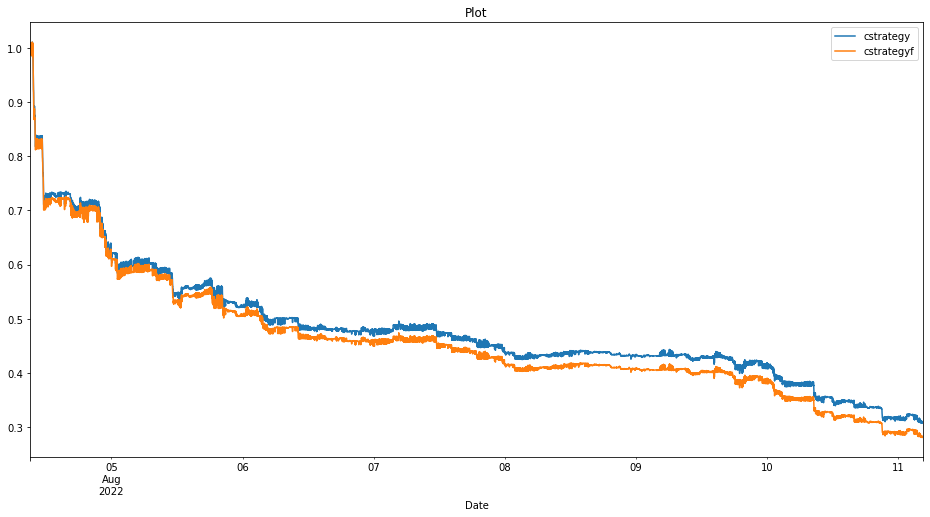

In [207]:
df[["cstrategy", "cstrategyf"]].plot(kind="line", title="Plot", figsize=(16, 8))

# Changing settings

In [2]:
from binance.client import Client
import pandas as pd

client = Client(api_key = api_key, api_secret = secret_key, tld = "com", testnet = True) # Testnet!!!

### Leverage

In [3]:
client.futures_change_leverage(symbol = "BTCUSDT", leverage = 6)

{'symbol': 'BTCUSDT', 'leverage': 6, 'maxNotionalValue': '20000000'}

### Margin

In [4]:
client.futures_change_margin_type(symbol = "BTCUSDT", marginType = "ISOLATED") #or CROSSED

BinanceAPIException: APIError(code=-4046): No need to change margin type.

### Position mode (Netting and Hedging)

In [3]:
client.futures_get_position_mode() 

{'dualSidePosition': False}

In [6]:
client.futures_change_position_mode(dualSidePosition = False) 

{'code': 200, 'msg': 'success'}

# General info

In [7]:
client.futures_account() # Account details

{'feeTier': 0,
 'canTrade': True,
 'canDeposit': True,
 'canWithdraw': True,
 'updateTime': 0,
 'totalInitialMargin': '0.00000000',
 'totalMaintMargin': '0.00000000',
 'totalWalletBalance': '2998.00489121',
 'totalUnrealizedProfit': '0.00000000',
 'totalMarginBalance': '2998.00489121',
 'totalPositionInitialMargin': '0.00000000',
 'totalOpenOrderInitialMargin': '0.00000000',
 'totalCrossWalletBalance': '2998.00489121',
 'totalCrossUnPnl': '0.00000000',
 'availableBalance': '2998.00489121',
 'maxWithdrawAmount': '2998.00489121',
 'assets': [{'asset': 'BNB',
   'walletBalance': '0.00000000',
   'unrealizedProfit': '0.00000000',
   'marginBalance': '0.00000000',
   'maintMargin': '0.00000000',
   'initialMargin': '0.00000000',
   'positionInitialMargin': '0.00000000',
   'openOrderInitialMargin': '0.00000000',
   'maxWithdrawAmount': '0.00000000',
   'crossWalletBalance': '0.00000000',
   'crossUnPnl': '0.00000000',
   'availableBalance': '0.00000000',
   'marginAvailable': True,
   'upda

In [8]:
pd.DataFrame(client.futures_account()["assets"])

,asset,walletBalance,unrealizedProfit,marginBalance,maintMargin,initialMargin,positionInitialMargin,openOrderInitialMargin,maxWithdrawAmount,crossWalletBalance,crossUnPnl,availableBalance,marginAvailable,updateTime
0,BNB,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,True,0
1,USDT,2998.00489121,0.00000000,2998.00489121,0.00000000,0.00000000,0.00000000,0.00000000,2998.00489121,2998.00489121,0.00000000,2998.00489121,True,1660438112624
2,BUSD,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,True,0


In [32]:
balance = pd.DataFrame(client.futures_account_balance())# Asset Balance details
balance

,accountAlias,asset,balance,withdrawAvailable,updateTime
0,FzuXfWSgmYFzmY,BTC,0.00000000,0.00000000,0
1,FzuXfWSgmYFzmY,BNB,0.00000000,0.00000000,0
2,FzuXfWSgmYFzmY,ETH,0.00000000,0.00000000,0
3,FzuXfWSgmYFzmY,USDT,2986.81448165,2986.81448165,1660891086056
4,FzuXfWSgmYFzmY,USDC,0.00000000,0.00000000,0
5,FzuXfWSgmYFzmY,BUSD,0.00000000,0.00000000,0


In [33]:
balance = float(balance[ balance["asset"] == "USDT" ].iloc[0]["balance"])
balance

2986.81448165

In [10]:
client.futures_position_information() # current Open Positions

[{'symbol': 'RAYUSDT',
  'positionAmt': '0.0',
  'entryPrice': '0.0',
  'markPrice': '0.00000000',
  'unRealizedProfit': '0.00000000',
  'liquidationPrice': '0',
  'leverage': '20',
  'maxNotionalValue': '25000',
  'marginType': 'cross',
  'isolatedMargin': '0.00000000',
  'isAutoAddMargin': 'false',
  'positionSide': 'BOTH',
  'notional': '0',
  'isolatedWallet': '0',
  'updateTime': 0},
 {'symbol': 'API3USDT',
  'positionAmt': '0.0',
  'entryPrice': '0.0',
  'markPrice': '0.00000000',
  'unRealizedProfit': '0.00000000',
  'liquidationPrice': '0',
  'leverage': '20',
  'maxNotionalValue': '25000',
  'marginType': 'cross',
  'isolatedMargin': '0.00000000',
  'isAutoAddMargin': 'false',
  'positionSide': 'BOTH',
  'notional': '0',
  'isolatedWallet': '0',
  'updateTime': 0},
 {'symbol': 'SUSHIUSDT',
  'positionAmt': '0',
  'entryPrice': '0.0',
  'markPrice': '0.00000000',
  'unRealizedProfit': '0.00000000',
  'liquidationPrice': '0',
  'leverage': '20',
  'maxNotionalValue': '25000',
  

In [11]:
client.futures_position_information(symbol = "BTCUSDT") # current Open Positions for one symbol

[{'symbol': 'BTCUSDT',
  'positionAmt': '0.000',
  'entryPrice': '0.0',
  'markPrice': '24170.65498859',
  'unRealizedProfit': '0.00000000',
  'liquidationPrice': '0',
  'leverage': '1',
  'maxNotionalValue': '5.0E7',
  'marginType': 'isolated',
  'isolatedMargin': '0.00000000',
  'isAutoAddMargin': 'false',
  'positionSide': 'BOTH',
  'notional': '0',
  'isolatedWallet': '0',
  'updateTime': 1660438112624}]

In [12]:
client.futures_get_open_orders(symbol = "BTCUSDT") # current Open Orders for one symbol

[]

# Placing orders

In [34]:
leverage = 10
size = 0.01
client.futures_change_leverage(symbol = "BTCUSDT", leverage = leverage)

{'symbol': 'BTCUSDT', 'leverage': 10, 'maxNotionalValue': '20000000'}

In [35]:
order_open = client.futures_create_order(symbol = "BTCUSDT", side = "BUY",
                                         type = "MARKET", quantity = size)
order_open

{'orderId': 3258965759,
 'symbol': 'BTCUSDT',
 'status': 'NEW',
 'clientOrderId': 'IKJlsVMLcucMcMYYvADIDW',
 'price': '0',
 'avgPrice': '0.00000',
 'origQty': '0.010',
 'executedQty': '0',
 'cumQty': '0',
 'cumQuote': '0',
 'timeInForce': 'GTC',
 'type': 'MARKET',
 'reduceOnly': False,
 'closePosition': False,
 'side': 'BUY',
 'positionSide': 'BOTH',
 'stopPrice': '0',
 'workingType': 'CONTRACT_PRICE',
 'priceProtect': False,
 'origType': 'MARKET',
 'updateTime': 1670229038651}

In [37]:
order_open = client.futures_create_order(symbol = "BTCUSDT", side = "BUY",
                                         type = "MARKET", price = "500")
order_open

BinanceAPIException: APIError(code=-1102): A mandatory parameter was not sent, was empty/null, or malformed.

In [15]:
client.futures_get_order(symbol = "BTCUSDT", orderId = order_open["orderId"]) # check order status

{'orderId': 3196491311,
 'symbol': 'BTCUSDT',
 'status': 'FILLED',
 'clientOrderId': '8yrZgDZ2yI7t204flmoBvm',
 'price': '0',
 'avgPrice': '24179.70000',
 'origQty': '0.010',
 'executedQty': '0.010',
 'cumQuote': '241.79700',
 'timeInForce': 'GTC',
 'type': 'MARKET',
 'reduceOnly': False,
 'closePosition': False,
 'side': 'BUY',
 'positionSide': 'BOTH',
 'stopPrice': '0',
 'workingType': 'CONTRACT_PRICE',
 'priceProtect': False,
 'origType': 'MARKET',
 'time': 1660586908691,
 'updateTime': 1660586908691}

In [16]:
client.futures_position_information(symbol = "BTCUSDT") 

[{'symbol': 'BTCUSDT',
  'positionAmt': '0.010',
  'entryPrice': '24179.7',
  'markPrice': '24126.64749803',
  'unRealizedProfit': '-0.53052501',
  'liquidationPrice': '0',
  'leverage': '1',
  'maxNotionalValue': '5.0E7',
  'marginType': 'isolated',
  'isolatedMargin': '241.84536423',
  'isAutoAddMargin': 'false',
  'positionSide': 'BOTH',
  'notional': '241.26647498',
  'isolatedWallet': '242.37588924',
  'updateTime': 1660586908691}]

In [17]:
order_close = client.futures_create_order(symbol = "BTCUSDT", side = "SELL",
                                          type = "MARKET", quantity = size, reduceOnly = True)
order_close

{'orderId': 3196491913,
 'symbol': 'BTCUSDT',
 'status': 'NEW',
 'clientOrderId': 'dqHZDnRhbtNiupXZleKqgD',
 'price': '0',
 'avgPrice': '0.00000',
 'origQty': '0.010',
 'executedQty': '0',
 'cumQty': '0',
 'cumQuote': '0',
 'timeInForce': 'GTC',
 'type': 'MARKET',
 'reduceOnly': True,
 'closePosition': False,
 'side': 'SELL',
 'positionSide': 'BOTH',
 'stopPrice': '0',
 'workingType': 'CONTRACT_PRICE',
 'priceProtect': False,
 'origType': 'MARKET',
 'updateTime': 1660586974412}

In [18]:
client.futures_position_information(symbol = "BTCUSDT") 

[{'symbol': 'BTCUSDT',
  'positionAmt': '0.000',
  'entryPrice': '0.0',
  'markPrice': '24098.59533716',
  'unRealizedProfit': '0.00000000',
  'liquidationPrice': '0',
  'leverage': '1',
  'maxNotionalValue': '5.0E7',
  'marginType': 'isolated',
  'isolatedMargin': '0.00000000',
  'isAutoAddMargin': 'false',
  'positionSide': 'BOTH',
  'notional': '0',
  'isolatedWallet': '0',
  'updateTime': 1660586974412}]

## Trade and Income History

In [19]:
client.futures_account_trades(symbol = "BTCUSDT") # get all trades in the last 7 days

[{'symbol': 'BTCUSDT',
  'id': 239085654,
  'orderId': 3191753735,
  'side': 'BUY',
  'price': '23814.80',
  'qty': '0.010',
  'realizedPnl': '0',
  'marginAsset': 'USDT',
  'quoteQty': '238.14800',
  'commission': '0.09525920',
  'commissionAsset': 'USDT',
  'time': 1659998068019,
  'positionSide': 'BOTH',
  'maker': False,
  'buyer': True},
 {'symbol': 'BTCUSDT',
  'id': 239085748,
  'orderId': 3191756362,
  'side': 'SELL',
  'price': '23825.60',
  'qty': '0.010',
  'realizedPnl': '0.10800000',
  'marginAsset': 'USDT',
  'quoteQty': '238.25600',
  'commission': '0.09530240',
  'commissionAsset': 'USDT',
  'time': 1659998165184,
  'positionSide': 'BOTH',
  'maker': False,
  'buyer': False},
 {'symbol': 'BTCUSDT',
  'id': 239085770,
  'orderId': 3191756982,
  'side': 'SELL',
  'price': '23817.30',
  'qty': '0.002',
  'realizedPnl': '0',
  'marginAsset': 'USDT',
  'quoteQty': '47.63460',
  'commission': '0.01905384',
  'commissionAsset': 'USDT',
  'time': 1659998202017,
  'positionSide'

In [20]:
df = pd.DataFrame(client.futures_account_trades(symbol = "BTCUSDT"))
df

,symbol,id,orderId,side,price,qty,realizedPnl,marginAsset,quoteQty,commission,commissionAsset,time,positionSide,maker,buyer
0,BTCUSDT,239085654,3191753735,BUY,23814.80,0.010,0,USDT,238.14800,0.09525920,USDT,1659998068019,BOTH,False,True
1,BTCUSDT,239085748,3191756362,SELL,23825.60,0.010,0.10800000,USDT,238.25600,0.09530240,USDT,1659998165184,BOTH,False,False
2,BTCUSDT,239085770,3191756982,SELL,23817.30,0.002,0,USDT,47.63460,0.01905384,USDT,1659998202017,BOTH,False,False
3,BTCUSDT,239085771,3191756982,SELL,23817.30,0.002,0,USDT,47.63460,0.01905384,USDT,1659998202017,BOTH,False,False
4,BTCUSDT,239085772,3191756982,SELL,23811.20,0.006,0,USDT,142.86720,0.05714688,USDT,1659998202017,BOTH,False,False
5,BTCUSDT,239085779,3191757016,SELL,23817.30,0.010,0,USDT,238.17300,0.09526920,USDT,1659998204489,BOTH,False,False
6,BTCUSDT,239085782,3191757365,SELL,23808.20,0.010,0,USDT,238.08200,0.09523280,USDT,1659998212340,BOTH,False,False
7,BTCUSDT,239085791,3191757462,SELL,23819.90,0.010,0,USDT,238.19900,0.09527960,USDT,1659998222495,BOTH,False,False
8,BTCUSDT,239085816,3191757833,SELL,23818.10,0.010,0,USDT,238.18100,0.09527240,USDT,1659998270069,BOTH,False,False
9,BTCUSDT,239085839,3191758119,BUY,23827.50,0.050,-0.60359999,USDT,1191.37500,0.47655000,USDT,1659998308546,BOTH,False,True


In [21]:
df.tail(2) # two most recent trades

,symbol,id,orderId,side,price,qty,realizedPnl,marginAsset,quoteQty,commission,commissionAsset,time,positionSide,maker,buyer
18,BTCUSDT,239757553,3196491913,SELL,24249.10,0.001,0.06940000,USDT,24.24910,0.00969964,USDT,1660586974412,BOTH,False,False
19,BTCUSDT,239757554,3196491913,SELL,24220.70,0.009,0.36900000,USDT,217.98630,0.08719452,USDT,1660586974412,BOTH,False,False


In [22]:
client.futures_income_history(symbol = "BTCUSDT") # recent income history (7 days)

[{'symbol': 'BTCUSDT',
  'incomeType': 'COMMISSION',
  'income': '-0.09525920',
  'asset': 'USDT',
  'time': 1659998068000,
  'info': '239085654',
  'tranId': 90031239085654,
  'tradeId': '239085654'},
 {'symbol': 'BTCUSDT',
  'incomeType': 'REALIZED_PNL',
  'income': '0.10800000',
  'asset': 'USDT',
  'time': 1659998165000,
  'info': '239085748',
  'tranId': 90030239085748,
  'tradeId': '239085748'},
 {'symbol': 'BTCUSDT',
  'incomeType': 'COMMISSION',
  'income': '-0.09530240',
  'asset': 'USDT',
  'time': 1659998165000,
  'info': '239085748',
  'tranId': 90030239085748,
  'tradeId': '239085748'},
 {'symbol': 'BTCUSDT',
  'incomeType': 'COMMISSION',
  'income': '-0.01905384',
  'asset': 'USDT',
  'time': 1659998202000,
  'info': '239085770',
  'tranId': 90030239085770,
  'tradeId': '239085770'},
 {'symbol': 'BTCUSDT',
  'incomeType': 'COMMISSION',
  'income': '-0.01905384',
  'asset': 'USDT',
  'time': 1659998202000,
  'info': '239085771',
  'tranId': 90030239085771,
  'tradeId': '23

In [23]:
pd.DataFrame(client.futures_income_history(symbol = "BTCUSDT")).tail(3)

,symbol,incomeType,income,asset,time,info,tranId,tradeId
23,BTCUSDT,COMMISSION,-0.00969964,USDT,1660586974000,239757553,90030239757553,239757553
24,BTCUSDT,REALIZED_PNL,0.36900000,USDT,1660586974000,239757554,90030239757554,239757554
25,BTCUSDT,COMMISSION,-0.08719452,USDT,1660586974000,239757554,90030239757554,239757554


In [3]:
from binance.client import Client
import pandas as pd

client = Client(api_key = api_key, api_secret = secret_key, tld = "com", testnet = True) # Testnet!!!

In [4]:
leverage = 10
size = 0.01
client.futures_change_leverage(symbol = "BTCUSDT", leverage = leverage)
order_open = client.futures_create_order(symbol = "BTCUSDT", side = "BUY",
                                         type = "MARKET", quantity = size)
client.futures_get_order(symbol = "BTCUSDT", orderId = order_open["orderId"]) # check order status

{'orderId': 3197154689,
 'symbol': 'BTCUSDT',
 'status': 'FILLED',
 'clientOrderId': 'Bx9vCFsv6bwTuYQ5oh2dIK',
 'price': '0',
 'avgPrice': '24558.04000',
 'origQty': '0.010',
 'executedQty': '0.010',
 'cumQuote': '245.58040',
 'timeInForce': 'GTC',
 'type': 'MARKET',
 'reduceOnly': False,
 'closePosition': False,
 'side': 'BUY',
 'positionSide': 'BOTH',
 'stopPrice': '0',
 'workingType': 'CONTRACT_PRICE',
 'priceProtect': False,
 'origType': 'MARKET',
 'time': 1660682963485,
 'updateTime': 1660682963485}